# Readme

* To run this script, ensure that the folder *"NEU-CLS"* is extracted and placed in the base directory.
* The last checkpoint weights for the gan model is not included in zip file as it is a large file and could not be sent over the email.
* Samples of Generated Images are stored in gan_images folder (20 Images every 50 epochs starting from 150th epoch).
    1. Total Number Images Generated: 120
* Folders that are created after running notebook:
    1. gan_images
    2. weights

# Import Libraries

In [9]:
!pip install -r q3_requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms


# Hyperparameters

In [11]:
# Set the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Hyperparameters
dim = 100
num_epochs = 400
batch_size = 128
feat_map = 64
final_map = 3

# Create output directory
os.makedirs("gan_images", exist_ok=True)

cuda


# Preparation of Data

### Create Custom Dataset

In [12]:
# Create Custom Dataset
class GanDataset(Dataset):
    def __init__(self, root_path = './NEU-CLS'):
        self.root_path = root_path
        self.images = os.listdir(self.root_path)
       
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=(64, 64), antialias=True),
        ])
        
        return print('Dataset Loaded: ', len(self.images))
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        path = self.images[index]
        image_path = os.path.join(self.root_path, path)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        assert image is not None, "Image does not exist!"
        assert self.transform is not None, "Please specify your transformation!"
        return self.transform(image)    
    
dataset = GanDataset()

Dataset Loaded:  1800


### Create DataLoader

In [13]:
# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Models

### Initialisation of weights

In [14]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator Model

In [15]:
class Generator(nn.Module):
    def __init__(self, dim, feat_map, final_map):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(dim, feat_map * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feat_map * 8),
            nn.ReLU(True),
            # Out: 1024 x 4 x 4
            nn.ConvTranspose2d(feat_map * 8, feat_map * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feat_map * 4),
            nn.ReLU(True),
            # Out: 512 x 8 x 8
            nn.ConvTranspose2d(feat_map * 4, feat_map * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feat_map * 2),
            nn.ReLU(True),
            # Out: 256 x 16 x 16
            nn.ConvTranspose2d(feat_map * 2, feat_map, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feat_map),
            nn.ReLU(True),
            # Out: 128 x 32 x 32
            nn.ConvTranspose2d(feat_map, final_map, 4, 2, 1, bias=False),
            nn.Tanh()
            # Out: 3 x 64 x 64
        )

    def forward(self, z):
        return self.model(z)
    
generator = Generator(dim=dim, feat_map=feat_map, final_map=final_map).to(device)
generator.apply(weights_init)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

### Discriminator Model

In [16]:
class Discriminator(nn.Module):
    def __init__(self, feat_map, final_map):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(final_map, feat_map, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Out: 64 x 32 x 32
            nn.Conv2d(feat_map, feat_map * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feat_map * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Out: 128 x 16 x 16
            nn.Conv2d(feat_map * 2, feat_map * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feat_map * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Out: 256 x 8 x 8
            nn.Conv2d(feat_map * 4, feat_map * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feat_map * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Out: 512 x 4 x 4
            nn.Conv2d(feat_map * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # Out: 1
        )

    def forward(self, img):
        img = self.model(img)
        return img.view(img.shape[0], -1)
    
discriminator = Discriminator(feat_map=feat_map, final_map=final_map).to(device)
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

# Training

In [17]:
# Loss function
adversarial_loss = nn.BCELoss()
pixel_loss = nn.L1Loss()

# Optimizers
optimizer_G = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
total_d_loss = []
total_g_loss = []

for epoch in range(num_epochs):

    epoch_d_loss = 0
    epoch_g_loss = 0

    for step, real_imgs in enumerate(tqdm(dataloader,  desc="{}: Training".format(epoch+1))):
        generator.train()
        discriminator.train()
        batch_size = real_imgs.shape[0]
        real_imgs = real_imgs.to(device)

        
        # Discriminator Training
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)
        
        # Real
        discriminator.zero_grad()
        real_pred = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, real)

        # Fake
        noise = torch.randn(batch_size, dim, 1, 1).to(device)
        fake_imgs = generator(noise)
        fake_pred = discriminator(fake_imgs)
        d_fake_loss = adversarial_loss(fake_pred, fake)

        # Total Discriminator Loss (Ability to distinguish between real and fake)
        d_loss = d_real_loss + d_fake_loss
        total_d_loss.append(d_loss.item())
        epoch_d_loss += d_loss.item()
        d_loss.backward()
        optimizer_D.step()

        # Generator Training
        generator.zero_grad()

        # Adversarial Loss (Ability to generate extremely good fake)
        fake_imgs = generator(noise)
        fake_pred = discriminator(fake_imgs)
        g_fake_loss = adversarial_loss(fake_pred, real)
        g_pixel_loss = pixel_loss(fake_imgs, real_imgs)

        # Total Generator Loss
        g_loss = 0.9*g_fake_loss + 0.1 * g_pixel_loss
        total_g_loss.append(g_loss.item())
        epoch_g_loss += g_loss.item()
        g_loss.backward()
        optimizer_G.step()
        
    mean_d_loss = epoch_d_loss / len(dataloader)
    mean_g_loss = epoch_g_loss / len(dataloader)

    print('{} - D_Loss: {}, G_Loss: {}'.format(epoch+1, mean_d_loss, mean_g_loss))
    
    # Save 20 Sample Gan Images Every 50 epochs starting from 150 epoch
    if (epoch + 1) > 100:
        if (epoch + 1) % 50 == 0:
            generator.eval()
            with torch.no_grad():
                gan_batch = 20
                count = 1
                noise = torch.randn(gan_batch, dim, 1, 1).to(device)
                imgs = generator(noise).cpu().numpy().transpose(0, 2, 3, 1)
                for img in imgs:
                    img = img * 255
                    path = '{}_{}.jpeg'.format(epoch+1, count)
                    img_path = os.path.join('gan_images', path)
                    cv2.imwrite(img_path, img)
                    count += 1


# Save Last Weights
os.makedirs('weights', exist_ok=True)
state = {
    'Generator': generator.state_dict(),
    'Discriminator': discriminator.state_dict()
}
torch.save(state, './weights/d_{:.2f}_g{:.2f}'.format(epoch+1, mean_d_loss, mean_g_loss))

1: Training: 100%|██████████| 15/15 [00:04<00:00,  3.24it/s]


1 - D_Loss: 0.6102102021376292, G_Loss: 6.2274700482686365


2: Training: 100%|██████████| 15/15 [00:01<00:00,  8.24it/s]


2 - D_Loss: 0.11846232120490943, G_Loss: 11.752283636728922


3: Training: 100%|██████████| 15/15 [00:01<00:00,  8.23it/s]


3 - D_Loss: 0.37512248697069783, G_Loss: 15.117765967051188


4: Training: 100%|██████████| 15/15 [00:01<00:00,  8.26it/s]


4 - D_Loss: 1.1540096746990458, G_Loss: 16.295885594685874


5: Training: 100%|██████████| 15/15 [00:01<00:00,  8.31it/s]


5 - D_Loss: 0.4085286311184367, G_Loss: 14.222826194763183


6: Training: 100%|██████████| 15/15 [00:01<00:00,  8.25it/s]


6 - D_Loss: 0.35725520352522533, G_Loss: 8.319033605853717


7: Training: 100%|██████████| 15/15 [00:01<00:00,  8.38it/s]


7 - D_Loss: 1.4884623785813649, G_Loss: 5.410754068692525


8: Training: 100%|██████████| 15/15 [00:01<00:00,  8.52it/s]


8 - D_Loss: 1.1515061338742574, G_Loss: 2.7353459363182386


9: Training: 100%|██████████| 15/15 [00:01<00:00,  8.45it/s]


9 - D_Loss: 1.1419181903203328, G_Loss: 2.165579601128896


10: Training: 100%|██████████| 15/15 [00:01<00:00,  8.51it/s]


10 - D_Loss: 1.2428652842839558, G_Loss: 1.7848987638950349


11: Training: 100%|██████████| 15/15 [00:01<00:00,  8.41it/s]


11 - D_Loss: 1.183156947294871, G_Loss: 1.6776503721872966


12: Training: 100%|██████████| 15/15 [00:01<00:00,  8.37it/s]


12 - D_Loss: 1.1162036220232645, G_Loss: 1.8185163378715514


13: Training: 100%|██████████| 15/15 [00:01<00:00,  8.41it/s]


13 - D_Loss: 1.5138514479001364, G_Loss: 1.2576385150353113


14: Training: 100%|██████████| 15/15 [00:01<00:00,  8.43it/s]


14 - D_Loss: 1.310145366191864, G_Loss: 1.2458798249562582


15: Training: 100%|██████████| 15/15 [00:01<00:00,  8.61it/s]


15 - D_Loss: 1.0066723664601644, G_Loss: 1.5219591418902079


16: Training: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


16 - D_Loss: 0.9885579427083333, G_Loss: 2.033235541979472


17: Training: 100%|██████████| 15/15 [00:01<00:00,  8.48it/s]


17 - D_Loss: 1.107206928730011, G_Loss: 1.4426960905392965


18: Training: 100%|██████████| 15/15 [00:01<00:00,  8.60it/s]


18 - D_Loss: 1.141683248678843, G_Loss: 1.8725290030241013


19: Training: 100%|██████████| 15/15 [00:01<00:00,  8.53it/s]


19 - D_Loss: 1.0218364596366882, G_Loss: 1.9512303829193116


20: Training: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


20 - D_Loss: 0.9220593174298605, G_Loss: 2.1559087693691255


21: Training: 100%|██████████| 15/15 [00:01<00:00,  8.47it/s]


21 - D_Loss: 0.3821916341781616, G_Loss: 3.2244922002156575


22: Training: 100%|██████████| 15/15 [00:01<00:00,  8.38it/s]


22 - D_Loss: 0.3161011745532354, G_Loss: 3.128520647684733


23: Training: 100%|██████████| 15/15 [00:01<00:00,  8.55it/s]


23 - D_Loss: 0.32282351950804394, G_Loss: 4.032790533701578


24: Training: 100%|██████████| 15/15 [00:01<00:00,  8.53it/s]


24 - D_Loss: 0.9006984571615855, G_Loss: 3.540442609786987


25: Training: 100%|██████████| 15/15 [00:01<00:00,  8.52it/s]


25 - D_Loss: 0.35881286263465884, G_Loss: 3.0862391153971354


26: Training: 100%|██████████| 15/15 [00:01<00:00,  8.49it/s]


26 - D_Loss: 0.39090054233868915, G_Loss: 2.7318180720011394


27: Training: 100%|██████████| 15/15 [00:01<00:00,  8.51it/s]


27 - D_Loss: 0.3720213790734609, G_Loss: 3.350004243850708


28: Training: 100%|██████████| 15/15 [00:01<00:00,  8.53it/s]


28 - D_Loss: 0.6837421814600627, G_Loss: 3.7813337723414104


29: Training: 100%|██████████| 15/15 [00:01<00:00,  8.45it/s]


29 - D_Loss: 0.5853376865386963, G_Loss: 2.9818517026801903


30: Training: 100%|██████████| 15/15 [00:01<00:00,  8.59it/s]


30 - D_Loss: 1.9387989560763041, G_Loss: 1.928641680876414


31: Training: 100%|██████████| 15/15 [00:01<00:00,  8.55it/s]


31 - D_Loss: 1.0358152747154237, G_Loss: 2.356425682703654


32: Training: 100%|██████████| 15/15 [00:01<00:00,  8.52it/s]


32 - D_Loss: 1.1368457118670146, G_Loss: 2.594703844189644


33: Training: 100%|██████████| 15/15 [00:01<00:00,  8.48it/s]


33 - D_Loss: 1.044344566265742, G_Loss: 2.2641155819098153


34: Training: 100%|██████████| 15/15 [00:01<00:00,  8.43it/s]


34 - D_Loss: 0.55948579510053, G_Loss: 2.359490251541138


35: Training: 100%|██████████| 15/15 [00:01<00:00,  8.52it/s]


35 - D_Loss: 0.4458172579606374, G_Loss: 2.637534006436666


36: Training: 100%|██████████| 15/15 [00:01<00:00,  8.58it/s]


36 - D_Loss: 0.5229803264141083, G_Loss: 2.86751972536246


37: Training: 100%|██████████| 15/15 [00:01<00:00,  8.48it/s]


37 - D_Loss: 0.8946000059445699, G_Loss: 3.1828446944554645


38: Training: 100%|██████████| 15/15 [00:01<00:00,  8.41it/s]


38 - D_Loss: 1.2592084129651389, G_Loss: 3.0610775887966155


39: Training: 100%|██████████| 15/15 [00:01<00:00,  8.33it/s]


39 - D_Loss: 1.1392066121101379, G_Loss: 2.6365666230519613


40: Training: 100%|██████████| 15/15 [00:01<00:00,  8.49it/s]


40 - D_Loss: 0.8085119664669037, G_Loss: 3.1421623388926188


41: Training: 100%|██████████| 15/15 [00:01<00:00,  8.53it/s]


41 - D_Loss: 0.7296029269695282, G_Loss: 2.0888150095939637


42: Training: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


42 - D_Loss: 1.3701568086942038, G_Loss: 2.4488577405611673


43: Training: 100%|██████████| 15/15 [00:01<00:00,  8.44it/s]


43 - D_Loss: 0.7155498425165813, G_Loss: 2.6583356142044066


44: Training: 100%|██████████| 15/15 [00:01<00:00,  8.38it/s]


44 - D_Loss: 1.0411321779092153, G_Loss: 3.3993708451588946


45: Training: 100%|██████████| 15/15 [00:01<00:00,  8.48it/s]


45 - D_Loss: 0.7732407033443451, G_Loss: 2.829677939414978


46: Training: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


46 - D_Loss: 0.6312658866246541, G_Loss: 2.3465615049004556


47: Training: 100%|██████████| 15/15 [00:01<00:00,  8.39it/s]


47 - D_Loss: 1.1207675059636435, G_Loss: 1.7749454895655314


48: Training: 100%|██████████| 15/15 [00:01<00:00,  8.43it/s]


48 - D_Loss: 0.9412065049012502, G_Loss: 2.1217447027564047


49: Training: 100%|██████████| 15/15 [00:01<00:00,  8.49it/s]


49 - D_Loss: 0.9537211279074351, G_Loss: 2.305461859703064


50: Training: 100%|██████████| 15/15 [00:01<00:00,  8.52it/s]


50 - D_Loss: 0.7627971371014913, G_Loss: 2.334650913874308


51: Training: 100%|██████████| 15/15 [00:01<00:00,  8.55it/s]


51 - D_Loss: 0.5530702829360962, G_Loss: 2.2981873671213786


52: Training: 100%|██████████| 15/15 [00:01<00:00,  8.48it/s]


52 - D_Loss: 0.6409287025531133, G_Loss: 2.749457017580668


53: Training: 100%|██████████| 15/15 [00:01<00:00,  8.33it/s]


53 - D_Loss: 0.570495331287384, G_Loss: 2.6195382674535117


54: Training: 100%|██████████| 15/15 [00:01<00:00,  8.51it/s]


54 - D_Loss: 0.4992574910322825, G_Loss: 2.737959694862366


55: Training: 100%|██████████| 15/15 [00:01<00:00,  8.54it/s]


55 - D_Loss: 0.619461065530777, G_Loss: 2.5287619988123575


56: Training: 100%|██████████| 15/15 [00:01<00:00,  8.53it/s]


56 - D_Loss: 1.1446117401123046, G_Loss: 2.0197330554326376


57: Training: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


57 - D_Loss: 0.8474163770675659, G_Loss: 1.8600019256273905


58: Training: 100%|██████████| 15/15 [00:01<00:00,  8.45it/s]


58 - D_Loss: 0.9597715298334758, G_Loss: 2.423313013712565


59: Training: 100%|██████████| 15/15 [00:01<00:00,  8.34it/s]


59 - D_Loss: 0.7081193864345551, G_Loss: 2.2284172058105467


60: Training: 100%|██████████| 15/15 [00:01<00:00,  8.49it/s]


60 - D_Loss: 0.715141890446345, G_Loss: 2.663784416516622


61: Training: 100%|██████████| 15/15 [00:01<00:00,  8.22it/s]


61 - D_Loss: 0.8641172925631205, G_Loss: 2.2328100005785623


62: Training: 100%|██████████| 15/15 [00:01<00:00,  8.23it/s]


62 - D_Loss: 0.7415430347124735, G_Loss: 2.4793256918589273


63: Training: 100%|██████████| 15/15 [00:01<00:00,  8.44it/s]


63 - D_Loss: 0.7512615044911702, G_Loss: 2.1237553040186565


64: Training: 100%|██████████| 15/15 [00:01<00:00,  8.36it/s]


64 - D_Loss: 0.7729114572207133, G_Loss: 2.106310256322225


65: Training: 100%|██████████| 15/15 [00:01<00:00,  8.05it/s]


65 - D_Loss: 0.9752040465672811, G_Loss: 1.889801283677419


66: Training: 100%|██████████| 15/15 [00:01<00:00,  7.83it/s]


66 - D_Loss: 0.7712380806605021, G_Loss: 2.04822096824646


67: Training: 100%|██████████| 15/15 [00:02<00:00,  7.26it/s]


67 - D_Loss: 0.7560051441192627, G_Loss: 2.4112591822942098


68: Training: 100%|██████████| 15/15 [00:02<00:00,  7.31it/s]


68 - D_Loss: 0.8262544870376587, G_Loss: 2.3317957401275633


69: Training: 100%|██████████| 15/15 [00:01<00:00,  7.68it/s]


69 - D_Loss: 0.8399804870287577, G_Loss: 2.081170920530955


70: Training: 100%|██████████| 15/15 [00:01<00:00,  7.86it/s]


70 - D_Loss: 0.982574991385142, G_Loss: 2.3677738587061565


71: Training: 100%|██████████| 15/15 [00:01<00:00,  8.04it/s]


71 - D_Loss: 0.9116469422976176, G_Loss: 2.131500514348348


72: Training: 100%|██████████| 15/15 [00:01<00:00,  8.02it/s]


72 - D_Loss: 0.7992539286613465, G_Loss: 2.0884199062983195


73: Training: 100%|██████████| 15/15 [00:01<00:00,  8.43it/s]


73 - D_Loss: 0.8335839351018269, G_Loss: 2.0880841255187987


74: Training: 100%|██████████| 15/15 [00:01<00:00,  8.43it/s]


74 - D_Loss: 0.8153046329816183, G_Loss: 2.2989896297454835


75: Training: 100%|██████████| 15/15 [00:01<00:00,  8.13it/s]


75 - D_Loss: 1.0343119780222574, G_Loss: 1.886416757106781


76: Training: 100%|██████████| 15/15 [00:01<00:00,  8.30it/s]


76 - D_Loss: 0.8864278733730316, G_Loss: 2.1491201082865397


77: Training: 100%|██████████| 15/15 [00:01<00:00,  8.01it/s]


77 - D_Loss: 0.7580153822898865, G_Loss: 1.9900532722473145


78: Training: 100%|██████████| 15/15 [00:01<00:00,  8.18it/s]


78 - D_Loss: 0.7851392944653829, G_Loss: 2.0584308743476867


79: Training: 100%|██████████| 15/15 [00:01<00:00,  8.48it/s]


79 - D_Loss: 1.0828307112058004, G_Loss: 2.013448258241018


80: Training: 100%|██████████| 15/15 [00:01<00:00,  8.31it/s]


80 - D_Loss: 0.7534885783990224, G_Loss: 2.01716734568278


81: Training: 100%|██████████| 15/15 [00:01<00:00,  8.41it/s]


81 - D_Loss: 0.863412868976593, G_Loss: 1.9795056263605753


82: Training: 100%|██████████| 15/15 [00:01<00:00,  8.40it/s]


82 - D_Loss: 0.8144453287124633, G_Loss: 2.1361124912897744


83: Training: 100%|██████████| 15/15 [00:01<00:00,  8.37it/s]


83 - D_Loss: 0.8996965249379476, G_Loss: 2.2497843345006308


84: Training: 100%|██████████| 15/15 [00:01<00:00,  8.37it/s]


84 - D_Loss: 0.8189382910728454, G_Loss: 2.0505288521448772


85: Training: 100%|██████████| 15/15 [00:01<00:00,  8.45it/s]


85 - D_Loss: 1.133263639609019, G_Loss: 1.744779258966446


86: Training: 100%|██████████| 15/15 [00:01<00:00,  8.45it/s]


86 - D_Loss: 1.1687356034914653, G_Loss: 1.8198892672856648


87: Training: 100%|██████████| 15/15 [00:01<00:00,  8.09it/s]


87 - D_Loss: 1.0145727276802063, G_Loss: 1.8330847839514415


88: Training: 100%|██████████| 15/15 [00:01<00:00,  8.23it/s]


88 - D_Loss: 1.207998756567637, G_Loss: 1.81517413854599


89: Training: 100%|██████████| 15/15 [00:01<00:00,  8.27it/s]


89 - D_Loss: 0.8017157673835754, G_Loss: 2.3078373432159425


90: Training: 100%|██████████| 15/15 [00:01<00:00,  8.39it/s]


90 - D_Loss: 0.7612161954243978, G_Loss: 1.9387982333699862


91: Training: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


91 - D_Loss: 1.3271202365557353, G_Loss: 2.009663200378418


92: Training: 100%|██████████| 15/15 [00:01<00:00,  8.49it/s]


92 - D_Loss: 0.7857578873634339, G_Loss: 2.04296555519104


93: Training: 100%|██████████| 15/15 [00:01<00:00,  8.44it/s]


93 - D_Loss: 0.7651403725147248, G_Loss: 2.115067517757416


94: Training: 100%|██████████| 15/15 [00:01<00:00,  8.55it/s]


94 - D_Loss: 0.5678616921106975, G_Loss: 2.2009861628214518


95: Training: 100%|██████████| 15/15 [00:01<00:00,  8.42it/s]


95 - D_Loss: 0.7458147684733073, G_Loss: 2.199530585606893


96: Training: 100%|██████████| 15/15 [00:01<00:00,  8.43it/s]


96 - D_Loss: 0.670053901274999, G_Loss: 2.17394224802653


97: Training: 100%|██████████| 15/15 [00:01<00:00,  8.54it/s]


97 - D_Loss: 0.812958445151647, G_Loss: 2.3612836519877116


98: Training: 100%|██████████| 15/15 [00:01<00:00,  8.45it/s]


98 - D_Loss: 0.8617624362309774, G_Loss: 2.186242039998372


99: Training: 100%|██████████| 15/15 [00:01<00:00,  8.47it/s]


99 - D_Loss: 1.128239099184672, G_Loss: 1.9423607846101125


100: Training: 100%|██████████| 15/15 [00:01<00:00,  8.44it/s]


100 - D_Loss: 0.7392328480879465, G_Loss: 2.09655974706014


101: Training: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


101 - D_Loss: 0.7925710856914521, G_Loss: 2.2192083875338238


102: Training: 100%|██████████| 15/15 [00:01<00:00,  8.46it/s]


102 - D_Loss: 0.9407516360282898, G_Loss: 1.8587079246838887


103: Training: 100%|██████████| 15/15 [00:01<00:00,  8.48it/s]


103 - D_Loss: 0.9820613781611125, G_Loss: 2.1409115274747212


104: Training: 100%|██████████| 15/15 [00:01<00:00,  8.51it/s]


104 - D_Loss: 1.0302177707354228, G_Loss: 2.012252163887024


105: Training: 100%|██████████| 15/15 [00:01<00:00,  8.35it/s]


105 - D_Loss: 0.7290667573610942, G_Loss: 2.3181171814600625


106: Training: 100%|██████████| 15/15 [00:01<00:00,  8.40it/s]


106 - D_Loss: 0.6485759119192759, G_Loss: 2.1661553462346395


107: Training: 100%|██████████| 15/15 [00:01<00:00,  8.55it/s]


107 - D_Loss: 0.7987686117490133, G_Loss: 2.1444297552108766


108: Training: 100%|██████████| 15/15 [00:01<00:00,  8.48it/s]


108 - D_Loss: 0.9842584451039632, G_Loss: 2.096336762110392


109: Training: 100%|██████████| 15/15 [00:01<00:00,  8.48it/s]


109 - D_Loss: 0.7235319018363953, G_Loss: 2.4841949939727783


110: Training: 100%|██████████| 15/15 [00:01<00:00,  8.18it/s]


110 - D_Loss: 0.8206152458985646, G_Loss: 2.201169455051422


111: Training: 100%|██████████| 15/15 [00:01<00:00,  8.43it/s]


111 - D_Loss: 0.8397050201892853, G_Loss: 2.387104578812917


112: Training: 100%|██████████| 15/15 [00:01<00:00,  8.44it/s]


112 - D_Loss: 0.9667782644430797, G_Loss: 2.2172252933184304


113: Training: 100%|██████████| 15/15 [00:01<00:00,  8.41it/s]


113 - D_Loss: 0.6728385408719381, G_Loss: 2.299266850948334


114: Training: 100%|██████████| 15/15 [00:01<00:00,  8.39it/s]


114 - D_Loss: 0.7392395416895549, G_Loss: 2.3058120727539064


115: Training: 100%|██████████| 15/15 [00:01<00:00,  8.37it/s]


115 - D_Loss: 0.625732974211375, G_Loss: 2.1680423910419147


116: Training: 100%|██████████| 15/15 [00:01<00:00,  8.30it/s]


116 - D_Loss: 0.9052334666252136, G_Loss: 2.445168121655782


117: Training: 100%|██████████| 15/15 [00:01<00:00,  8.23it/s]


117 - D_Loss: 0.6361169199148814, G_Loss: 2.520153073469798


118: Training: 100%|██████████| 15/15 [00:01<00:00,  8.47it/s]


118 - D_Loss: 0.6689129988352458, G_Loss: 2.478394548098246


119: Training: 100%|██████████| 15/15 [00:01<00:00,  8.46it/s]


119 - D_Loss: 0.7644744932651519, G_Loss: 2.342753529548645


120: Training: 100%|██████████| 15/15 [00:01<00:00,  8.45it/s]


120 - D_Loss: 0.5496799111366272, G_Loss: 2.390432373682658


121: Training: 100%|██████████| 15/15 [00:01<00:00,  8.48it/s]


121 - D_Loss: 0.6063245505094528, G_Loss: 2.847309637069702


122: Training: 100%|██████████| 15/15 [00:01<00:00,  8.51it/s]


122 - D_Loss: 0.6253040164709092, G_Loss: 2.5914941703279815


123: Training: 100%|██████████| 15/15 [00:01<00:00,  8.45it/s]


123 - D_Loss: 1.0918972611427307, G_Loss: 2.3144270817438763


124: Training: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


124 - D_Loss: 0.5565321147441864, G_Loss: 2.322770524024963


125: Training: 100%|██████████| 15/15 [00:01<00:00,  8.35it/s]


125 - D_Loss: 0.9034708499908447, G_Loss: 2.4591835896174112


126: Training: 100%|██████████| 15/15 [00:01<00:00,  8.46it/s]


126 - D_Loss: 0.5415773848692577, G_Loss: 2.589012098312378


127: Training: 100%|██████████| 15/15 [00:01<00:00,  8.51it/s]


127 - D_Loss: 0.8419253627459208, G_Loss: 2.497741042574247


128: Training: 100%|██████████| 15/15 [00:01<00:00,  8.42it/s]


128 - D_Loss: 0.860996679464976, G_Loss: 2.6085731585820517


129: Training: 100%|██████████| 15/15 [00:01<00:00,  8.51it/s]


129 - D_Loss: 0.6789964159329732, G_Loss: 2.312903968493144


130: Training: 100%|██████████| 15/15 [00:01<00:00,  8.45it/s]


130 - D_Loss: 1.5227911233901978, G_Loss: 1.6257165829340616


131: Training: 100%|██████████| 15/15 [00:01<00:00,  8.55it/s]


131 - D_Loss: 1.0119110067685446, G_Loss: 1.7087713042894999


132: Training: 100%|██████████| 15/15 [00:01<00:00,  8.43it/s]


132 - D_Loss: 0.6600624759991963, G_Loss: 2.1101850589116413


133: Training: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


133 - D_Loss: 1.0884922862052917, G_Loss: 2.5082818349202474


134: Training: 100%|██████████| 15/15 [00:01<00:00,  8.53it/s]


134 - D_Loss: 0.5682911336421966, G_Loss: 2.2281801382700603


135: Training: 100%|██████████| 15/15 [00:01<00:00,  8.40it/s]


135 - D_Loss: 0.6836404701073965, G_Loss: 2.578054165840149


136: Training: 100%|██████████| 15/15 [00:01<00:00,  8.47it/s]


136 - D_Loss: 0.6813547939062119, G_Loss: 2.3086952129999796


137: Training: 100%|██████████| 15/15 [00:01<00:00,  8.43it/s]


137 - D_Loss: 0.5259936491648356, G_Loss: 2.3662955443064373


138: Training: 100%|██████████| 15/15 [00:01<00:00,  8.51it/s]


138 - D_Loss: 0.6009931405385335, G_Loss: 2.338940175374349


139: Training: 100%|██████████| 15/15 [00:01<00:00,  8.48it/s]


139 - D_Loss: 0.5934069573879241, G_Loss: 2.267043407758077


140: Training: 100%|██████████| 15/15 [00:01<00:00,  8.43it/s]


140 - D_Loss: 0.8399404207865397, G_Loss: 2.5842822074890135


141: Training: 100%|██████████| 15/15 [00:01<00:00,  8.46it/s]


141 - D_Loss: 0.5673109610875448, G_Loss: 2.8443142890930178


142: Training: 100%|██████████| 15/15 [00:01<00:00,  8.56it/s]


142 - D_Loss: 0.5585616389910381, G_Loss: 2.5395267407099404


143: Training: 100%|██████████| 15/15 [00:01<00:00,  8.41it/s]


143 - D_Loss: 0.6930445889631908, G_Loss: 2.282500465710958


144: Training: 100%|██████████| 15/15 [00:01<00:00,  8.24it/s]


144 - D_Loss: 1.1523728867371876, G_Loss: 2.11213396191597


145: Training: 100%|██████████| 15/15 [00:01<00:00,  8.36it/s]


145 - D_Loss: 0.9360105733076731, G_Loss: 2.182086483637492


146: Training: 100%|██████████| 15/15 [00:01<00:00,  8.49it/s]


146 - D_Loss: 0.8182214399178823, G_Loss: 2.308732604980469


147: Training: 100%|██████████| 15/15 [00:01<00:00,  8.49it/s]


147 - D_Loss: 0.7533720990022024, G_Loss: 2.2980408549308775


148: Training: 100%|██████████| 15/15 [00:01<00:00,  8.47it/s]


148 - D_Loss: 0.7125354290008545, G_Loss: 2.3398300965627032


149: Training: 100%|██████████| 15/15 [00:01<00:00,  8.53it/s]


149 - D_Loss: 1.049542369445165, G_Loss: 2.4042458136876426


150: Training: 100%|██████████| 15/15 [00:01<00:00,  8.42it/s]


150 - D_Loss: 0.5384914676348368, G_Loss: 2.2347696940104167


151: Training: 100%|██████████| 15/15 [00:01<00:00,  8.25it/s]


151 - D_Loss: 0.5327610035737356, G_Loss: 2.2912891705830893


152: Training: 100%|██████████| 15/15 [00:01<00:00,  8.47it/s]


152 - D_Loss: 0.5631737192471822, G_Loss: 2.454581697781881


153: Training: 100%|██████████| 15/15 [00:01<00:00,  8.52it/s]


153 - D_Loss: 0.7478394150733948, G_Loss: 2.476184638341268


154: Training: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


154 - D_Loss: 0.7722740650177002, G_Loss: 2.50639816125234


155: Training: 100%|██████████| 15/15 [00:01<00:00,  8.32it/s]


155 - D_Loss: 1.0878540376822154, G_Loss: 2.494869621594747


156: Training: 100%|██████████| 15/15 [00:01<00:00,  8.49it/s]


156 - D_Loss: 0.7172488272190094, G_Loss: 2.5040873765945433


157: Training: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


157 - D_Loss: 0.7392478883266449, G_Loss: 2.5439709424972534


158: Training: 100%|██████████| 15/15 [00:01<00:00,  8.47it/s]


158 - D_Loss: 0.628349628051122, G_Loss: 2.2843160152435305


159: Training: 100%|██████████| 15/15 [00:01<00:00,  8.42it/s]


159 - D_Loss: 0.473894598086675, G_Loss: 2.3397585074106853


160: Training: 100%|██████████| 15/15 [00:01<00:00,  8.35it/s]


160 - D_Loss: 0.6242332637310029, G_Loss: 2.0958842506011326


161: Training: 100%|██████████| 15/15 [00:01<00:00,  8.44it/s]


161 - D_Loss: 1.0870116194089254, G_Loss: 2.8270483632882435


162: Training: 100%|██████████| 15/15 [00:01<00:00,  8.41it/s]


162 - D_Loss: 0.9283977568149566, G_Loss: 2.328544513384501


163: Training: 100%|██████████| 15/15 [00:01<00:00,  8.40it/s]


163 - D_Loss: 0.7406756997108459, G_Loss: 2.215497612953186


164: Training: 100%|██████████| 15/15 [00:01<00:00,  8.46it/s]


164 - D_Loss: 0.661059699455897, G_Loss: 2.2354723453521728


165: Training: 100%|██████████| 15/15 [00:01<00:00,  8.39it/s]


165 - D_Loss: 0.6566633621851603, G_Loss: 2.3067535559336343


166: Training: 100%|██████████| 15/15 [00:01<00:00,  8.49it/s]


166 - D_Loss: 0.6950141767660777, G_Loss: 2.1965896765391033


167: Training: 100%|██████████| 15/15 [00:01<00:00,  8.52it/s]


167 - D_Loss: 0.79321790933609, G_Loss: 2.3377135197321572


168: Training: 100%|██████████| 15/15 [00:01<00:00,  8.48it/s]


168 - D_Loss: 1.1271796186765035, G_Loss: 2.366439167658488


169: Training: 100%|██████████| 15/15 [00:01<00:00,  8.41it/s]


169 - D_Loss: 0.7567676186561585, G_Loss: 2.2748026768366496


170: Training: 100%|██████████| 15/15 [00:01<00:00,  8.47it/s]


170 - D_Loss: 0.5954721887906392, G_Loss: 2.275669741630554


171: Training: 100%|██████████| 15/15 [00:01<00:00,  8.59it/s]


171 - D_Loss: 0.6787574569384257, G_Loss: 2.1799379189809165


172: Training: 100%|██████████| 15/15 [00:01<00:00,  8.48it/s]


172 - D_Loss: 0.8493963837623596, G_Loss: 2.468504619598389


173: Training: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


173 - D_Loss: 0.859825466076533, G_Loss: 2.161732598145803


174: Training: 100%|██████████| 15/15 [00:01<00:00,  8.36it/s]


174 - D_Loss: 0.8685187061627706, G_Loss: 2.3597651084264117


175: Training: 100%|██████████| 15/15 [00:01<00:00,  8.52it/s]


175 - D_Loss: 0.7206873575846354, G_Loss: 2.394623629252116


176: Training: 100%|██████████| 15/15 [00:01<00:00,  8.46it/s]


176 - D_Loss: 0.6023085673650106, G_Loss: 2.4000258286794027


177: Training: 100%|██████████| 15/15 [00:01<00:00,  8.41it/s]


177 - D_Loss: 0.608630891640981, G_Loss: 2.4707131067911785


178: Training: 100%|██████████| 15/15 [00:01<00:00,  8.44it/s]


178 - D_Loss: 0.773356114824613, G_Loss: 2.355286451180776


179: Training: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


179 - D_Loss: 0.8457753519217174, G_Loss: 2.2191429773966473


180: Training: 100%|██████████| 15/15 [00:01<00:00,  8.48it/s]


180 - D_Loss: 1.0185577710469564, G_Loss: 2.6706143021583557


181: Training: 100%|██████████| 15/15 [00:01<00:00,  8.44it/s]


181 - D_Loss: 0.6156029462814331, G_Loss: 2.546004891395569


182: Training: 100%|██████████| 15/15 [00:01<00:00,  8.49it/s]


182 - D_Loss: 0.6944654564062754, G_Loss: 2.3692329009373982


183: Training: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


183 - D_Loss: 0.5707074503103892, G_Loss: 2.3180803060531616


184: Training: 100%|██████████| 15/15 [00:01<00:00,  8.47it/s]


184 - D_Loss: 0.7866876582304637, G_Loss: 2.2991108258565265


185: Training: 100%|██████████| 15/15 [00:01<00:00,  8.51it/s]


185 - D_Loss: 0.8964598079522451, G_Loss: 2.4109153906504313


186: Training: 100%|██████████| 15/15 [00:01<00:00,  8.52it/s]


186 - D_Loss: 1.059207836786906, G_Loss: 2.2773437102635703


187: Training: 100%|██████████| 15/15 [00:01<00:00,  8.38it/s]


187 - D_Loss: 0.831389860312144, G_Loss: 2.3683168331782025


188: Training: 100%|██████████| 15/15 [00:01<00:00,  8.53it/s]


188 - D_Loss: 0.44021209081013996, G_Loss: 2.5513169368108115


189: Training: 100%|██████████| 15/15 [00:01<00:00,  8.49it/s]


189 - D_Loss: 0.6576986988385518, G_Loss: 2.4291035175323485


190: Training: 100%|██████████| 15/15 [00:01<00:00,  8.53it/s]


190 - D_Loss: 0.8088545481363932, G_Loss: 2.2587480783462524


191: Training: 100%|██████████| 15/15 [00:01<00:00,  8.51it/s]


191 - D_Loss: 0.6556641817092895, G_Loss: 2.401906220118205


192: Training: 100%|██████████| 15/15 [00:01<00:00,  8.39it/s]


192 - D_Loss: 0.4712362339099248, G_Loss: 2.3044816891352338


193: Training: 100%|██████████| 15/15 [00:01<00:00,  8.47it/s]


193 - D_Loss: 0.6372857789198557, G_Loss: 2.3837640325228375


194: Training: 100%|██████████| 15/15 [00:01<00:00,  8.51it/s]


194 - D_Loss: 0.8053528885046641, G_Loss: 2.3763118267059324


195: Training: 100%|██████████| 15/15 [00:01<00:00,  8.46it/s]


195 - D_Loss: 0.463830778002739, G_Loss: 2.565276877085368


196: Training: 100%|██████████| 15/15 [00:01<00:00,  8.36it/s]


196 - D_Loss: 0.652909787495931, G_Loss: 2.6076569239298504


197: Training: 100%|██████████| 15/15 [00:01<00:00,  8.46it/s]


197 - D_Loss: 0.6235870679219564, G_Loss: 2.56419407526652


198: Training: 100%|██████████| 15/15 [00:01<00:00,  8.40it/s]


198 - D_Loss: 0.6631556530793508, G_Loss: 2.490570863087972


199: Training: 100%|██████████| 15/15 [00:01<00:00,  8.48it/s]


199 - D_Loss: 0.7359610001246134, G_Loss: 2.2858696142832438


200: Training: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


200 - D_Loss: 0.7614817301432292, G_Loss: 2.384472672144572


201: Training: 100%|██████████| 15/15 [00:01<00:00,  8.26it/s]


201 - D_Loss: 0.853000940879186, G_Loss: 2.4102771282196045


202: Training: 100%|██████████| 15/15 [00:01<00:00,  8.53it/s]


202 - D_Loss: 0.6744361519813538, G_Loss: 2.64694774945577


203: Training: 100%|██████████| 15/15 [00:01<00:00,  8.42it/s]


203 - D_Loss: 0.644238277276357, G_Loss: 2.5535639842351276


204: Training: 100%|██████████| 15/15 [00:01<00:00,  8.45it/s]


204 - D_Loss: 0.651390031973521, G_Loss: 2.388433233896891


205: Training: 100%|██████████| 15/15 [00:01<00:00,  8.41it/s]


205 - D_Loss: 0.7384631931781769, G_Loss: 2.398299241065979


206: Training: 100%|██████████| 15/15 [00:01<00:00,  7.98it/s]


206 - D_Loss: 0.47816200653711954, G_Loss: 2.5728487014770507


207: Training: 100%|██████████| 15/15 [00:01<00:00,  8.05it/s]


207 - D_Loss: 0.47607906262079874, G_Loss: 2.824845385551453


208: Training: 100%|██████████| 15/15 [00:01<00:00,  8.28it/s]


208 - D_Loss: 0.5815901120503744, G_Loss: 2.634485133488973


209: Training: 100%|██████████| 15/15 [00:01<00:00,  8.39it/s]


209 - D_Loss: 0.9285733143488566, G_Loss: 2.6316863854726154


210: Training: 100%|██████████| 15/15 [00:01<00:00,  8.38it/s]


210 - D_Loss: 0.7365504403909048, G_Loss: 2.6713784615198772


211: Training: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


211 - D_Loss: 0.8703015605608623, G_Loss: 2.557906913757324


212: Training: 100%|██████████| 15/15 [00:01<00:00,  8.45it/s]


212 - D_Loss: 0.9894666224718094, G_Loss: 2.5571547110875446


213: Training: 100%|██████████| 15/15 [00:01<00:00,  8.40it/s]


213 - D_Loss: 0.6464224914709727, G_Loss: 2.390002791086833


214: Training: 100%|██████████| 15/15 [00:01<00:00,  8.46it/s]


214 - D_Loss: 0.7584073921044667, G_Loss: 2.25053014755249


215: Training: 100%|██████████| 15/15 [00:01<00:00,  8.39it/s]


215 - D_Loss: 0.6544159690539042, G_Loss: 2.4509254455566407


216: Training: 100%|██████████| 15/15 [00:01<00:00,  8.41it/s]


216 - D_Loss: 0.6728119015693664, G_Loss: 2.3227185646692914


217: Training: 100%|██████████| 15/15 [00:01<00:00,  8.43it/s]


217 - D_Loss: 0.5697636365890503, G_Loss: 2.33659827709198


218: Training: 100%|██████████| 15/15 [00:01<00:00,  8.45it/s]


218 - D_Loss: 0.6105269114176433, G_Loss: 2.308925151824951


219: Training: 100%|██████████| 15/15 [00:01<00:00,  8.15it/s]


219 - D_Loss: 0.76377325852712, G_Loss: 2.3989761511484784


220: Training: 100%|██████████| 15/15 [00:01<00:00,  8.08it/s]


220 - D_Loss: 0.6293209075927735, G_Loss: 2.313954734802246


221: Training: 100%|██████████| 15/15 [00:01<00:00,  8.35it/s]


221 - D_Loss: 0.5427354037761688, G_Loss: 2.305772797266642


222: Training: 100%|██████████| 15/15 [00:01<00:00,  8.11it/s]


222 - D_Loss: 0.6896618942419688, G_Loss: 2.358833384513855


223: Training: 100%|██████████| 15/15 [00:01<00:00,  8.42it/s]


223 - D_Loss: 0.6637802531321844, G_Loss: 2.488689923286438


224: Training: 100%|██████████| 15/15 [00:01<00:00,  8.53it/s]


224 - D_Loss: 0.7447231789429982, G_Loss: 2.6604321002960205


225: Training: 100%|██████████| 15/15 [00:01<00:00,  8.43it/s]


225 - D_Loss: 0.6933061818281809, G_Loss: 2.523094681898753


226: Training: 100%|██████████| 15/15 [00:01<00:00,  8.38it/s]


226 - D_Loss: 0.7478480339050293, G_Loss: 2.664967385927836


227: Training: 100%|██████████| 15/15 [00:01<00:00,  8.41it/s]


227 - D_Loss: 0.6696015427509944, G_Loss: 2.715906500816345


228: Training: 100%|██████████| 15/15 [00:01<00:00,  8.35it/s]


228 - D_Loss: 0.5206725776195527, G_Loss: 2.432197364171346


229: Training: 100%|██████████| 15/15 [00:01<00:00,  8.30it/s]


229 - D_Loss: 0.5218998531500498, G_Loss: 2.491350269317627


230: Training: 100%|██████████| 15/15 [00:01<00:00,  8.29it/s]


230 - D_Loss: 0.4603017350037893, G_Loss: 2.4891445954640705


231: Training: 100%|██████████| 15/15 [00:01<00:00,  8.29it/s]


231 - D_Loss: 0.6469916065533956, G_Loss: 2.688871916135152


232: Training: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


232 - D_Loss: 0.7581538041432698, G_Loss: 2.3760967016220094


233: Training: 100%|██████████| 15/15 [00:01<00:00,  8.46it/s]


233 - D_Loss: 0.7075971325238546, G_Loss: 2.2863829533259072


234: Training: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


234 - D_Loss: 0.8908627092838287, G_Loss: 2.465515724817912


235: Training: 100%|██████████| 15/15 [00:01<00:00,  8.45it/s]


235 - D_Loss: 0.9890442967414856, G_Loss: 2.487313695748647


236: Training: 100%|██████████| 15/15 [00:01<00:00,  8.43it/s]


236 - D_Loss: 0.7856315056482951, G_Loss: 2.337005607287089


237: Training: 100%|██████████| 15/15 [00:01<00:00,  8.52it/s]


237 - D_Loss: 0.6860665202140808, G_Loss: 2.6228378772735597


238: Training: 100%|██████████| 15/15 [00:01<00:00,  8.51it/s]


238 - D_Loss: 0.8418950041135153, G_Loss: 2.4567071199417114


239: Training: 100%|██████████| 15/15 [00:01<00:00,  8.42it/s]


239 - D_Loss: 0.7542638162771861, G_Loss: 2.442466894785563


240: Training: 100%|██████████| 15/15 [00:01<00:00,  8.46it/s]


240 - D_Loss: 0.7772411495447159, G_Loss: 2.4763334592183432


241: Training: 100%|██████████| 15/15 [00:01<00:00,  8.47it/s]


241 - D_Loss: 0.6646998345851898, G_Loss: 2.472491784890493


242: Training: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


242 - D_Loss: 0.7674536089102427, G_Loss: 2.3817505757013957


243: Training: 100%|██████████| 15/15 [00:01<00:00,  8.47it/s]


243 - D_Loss: 0.6580625136693319, G_Loss: 2.7365328391393025


244: Training: 100%|██████████| 15/15 [00:01<00:00,  8.41it/s]


244 - D_Loss: 0.5477514743804932, G_Loss: 2.390563639005025


245: Training: 100%|██████████| 15/15 [00:01<00:00,  8.54it/s]


245 - D_Loss: 0.6350253542264302, G_Loss: 2.329376220703125


246: Training: 100%|██████████| 15/15 [00:01<00:00,  8.48it/s]


246 - D_Loss: 0.6192585130532583, G_Loss: 2.35623258749644


247: Training: 100%|██████████| 15/15 [00:01<00:00,  8.53it/s]


247 - D_Loss: 0.6804173310597738, G_Loss: 2.54874001344045


248: Training: 100%|██████████| 15/15 [00:01<00:00,  8.45it/s]


248 - D_Loss: 0.5811858673890432, G_Loss: 2.397819721698761


249: Training: 100%|██████████| 15/15 [00:01<00:00,  8.32it/s]


249 - D_Loss: 0.705120180050532, G_Loss: 2.679155969619751


250: Training: 100%|██████████| 15/15 [00:01<00:00,  8.48it/s]


250 - D_Loss: 0.6770960410435994, G_Loss: 2.2531310041745503


251: Training: 100%|██████████| 15/15 [00:01<00:00,  8.38it/s]


251 - D_Loss: 0.6042769213517507, G_Loss: 2.4716493129730224


252: Training: 100%|██████████| 15/15 [00:01<00:00,  8.53it/s]


252 - D_Loss: 0.6389986197153728, G_Loss: 2.3721885840098063


253: Training: 100%|██████████| 15/15 [00:01<00:00,  8.56it/s]


253 - D_Loss: 0.7243029276529948, G_Loss: 2.451948547363281


254: Training: 100%|██████████| 15/15 [00:01<00:00,  8.57it/s]


254 - D_Loss: 0.5096321662267049, G_Loss: 2.670889202753703


255: Training: 100%|██████████| 15/15 [00:01<00:00,  8.54it/s]


255 - D_Loss: 0.5180763999621073, G_Loss: 2.2652320782343547


256: Training: 100%|██████████| 15/15 [00:01<00:00,  8.66it/s]


256 - D_Loss: 0.6404511213302613, G_Loss: 2.129605225721995


257: Training: 100%|██████████| 15/15 [00:01<00:00,  9.00it/s]


257 - D_Loss: 0.6475669384002686, G_Loss: 2.502456227938334


258: Training: 100%|██████████| 15/15 [00:01<00:00,  9.00it/s]


258 - D_Loss: 0.46506445010503134, G_Loss: 2.414235782623291


259: Training: 100%|██████████| 15/15 [00:01<00:00,  8.89it/s]


259 - D_Loss: 0.4545108755429586, G_Loss: 2.4364033301671344


260: Training: 100%|██████████| 15/15 [00:01<00:00,  8.80it/s]


260 - D_Loss: 0.5135526627302169, G_Loss: 2.270029004414876


261: Training: 100%|██████████| 15/15 [00:01<00:00,  9.03it/s]


261 - D_Loss: 0.4987354298432668, G_Loss: 2.4067835489908855


262: Training: 100%|██████████| 15/15 [00:01<00:00,  8.85it/s]


262 - D_Loss: 0.6629716038703919, G_Loss: 2.560334499677022


263: Training: 100%|██████████| 15/15 [00:01<00:00,  8.98it/s]


263 - D_Loss: 0.4915121912956238, G_Loss: 2.754126723607381


264: Training: 100%|██████████| 15/15 [00:01<00:00,  8.89it/s]


264 - D_Loss: 0.47056223352750143, G_Loss: 2.3013337373733522


265: Training: 100%|██████████| 15/15 [00:01<00:00,  8.98it/s]


265 - D_Loss: 0.5012785494327545, G_Loss: 2.449049687385559


266: Training: 100%|██████████| 15/15 [00:01<00:00,  9.03it/s]


266 - D_Loss: 0.4827267090479533, G_Loss: 2.6783589363098144


267: Training: 100%|██████████| 15/15 [00:01<00:00,  8.90it/s]


267 - D_Loss: 0.5139009515444438, G_Loss: 2.4614193161328632


268: Training: 100%|██████████| 15/15 [00:01<00:00,  9.02it/s]


268 - D_Loss: 0.7514178584019343, G_Loss: 2.8091838439305623


269: Training: 100%|██████████| 15/15 [00:01<00:00,  8.97it/s]


269 - D_Loss: 0.5589607040087382, G_Loss: 2.6082006374994915


270: Training: 100%|██████████| 15/15 [00:01<00:00,  8.87it/s]


270 - D_Loss: 0.9410289525985718, G_Loss: 2.46015784740448


271: Training: 100%|██████████| 15/15 [00:01<00:00,  8.88it/s]


271 - D_Loss: 0.6498943547407786, G_Loss: 2.7123134613037108


272: Training: 100%|██████████| 15/15 [00:01<00:00,  8.88it/s]


272 - D_Loss: 0.7312725762526194, G_Loss: 2.333684460322062


273: Training: 100%|██████████| 15/15 [00:01<00:00,  8.94it/s]


273 - D_Loss: 0.5703861077626546, G_Loss: 2.4994539896647137


274: Training: 100%|██████████| 15/15 [00:01<00:00,  9.04it/s]


274 - D_Loss: 0.5133595585823059, G_Loss: 2.3422115325927733


275: Training: 100%|██████████| 15/15 [00:01<00:00,  8.98it/s]


275 - D_Loss: 0.6814236760139465, G_Loss: 2.425499931971232


276: Training: 100%|██████████| 15/15 [00:01<00:00,  9.00it/s]


276 - D_Loss: 0.6817999660968781, G_Loss: 2.5823360363642376


277: Training: 100%|██████████| 15/15 [00:01<00:00,  8.91it/s]


277 - D_Loss: 0.8127482563257218, G_Loss: 2.5764288902282715


278: Training: 100%|██████████| 15/15 [00:01<00:00,  8.94it/s]


278 - D_Loss: 0.6481444617112477, G_Loss: 2.400043280919393


279: Training: 100%|██████████| 15/15 [00:01<00:00,  8.90it/s]


279 - D_Loss: 0.7451429863770803, G_Loss: 2.3493913650512694


280: Training: 100%|██████████| 15/15 [00:01<00:00,  8.87it/s]


280 - D_Loss: 0.6891630868117015, G_Loss: 2.6933775424957274


281: Training: 100%|██████████| 15/15 [00:01<00:00,  8.93it/s]


281 - D_Loss: 0.5617603719234466, G_Loss: 2.567234985033671


282: Training: 100%|██████████| 15/15 [00:01<00:00,  8.96it/s]


282 - D_Loss: 0.6475905021031697, G_Loss: 2.611525050799052


283: Training: 100%|██████████| 15/15 [00:01<00:00,  8.86it/s]


283 - D_Loss: 0.5105747878551483, G_Loss: 2.7798168341318767


284: Training: 100%|██████████| 15/15 [00:01<00:00,  8.74it/s]


284 - D_Loss: 0.5563617666562398, G_Loss: 2.470962905883789


285: Training: 100%|██████████| 15/15 [00:01<00:00,  8.64it/s]


285 - D_Loss: 0.49073230624198916, G_Loss: 3.1690186818440753


286: Training: 100%|██████████| 15/15 [00:01<00:00,  8.95it/s]


286 - D_Loss: 0.5321603059768677, G_Loss: 2.645787008603414


287: Training: 100%|██████████| 15/15 [00:01<00:00,  8.90it/s]


287 - D_Loss: 0.585268638531367, G_Loss: 2.8352182706197104


288: Training: 100%|██████████| 15/15 [00:01<00:00,  8.91it/s]


288 - D_Loss: 0.5922445585330327, G_Loss: 2.603891626993815


289: Training: 100%|██████████| 15/15 [00:01<00:00,  8.85it/s]


289 - D_Loss: 0.5191331187884013, G_Loss: 2.673471275965373


290: Training: 100%|██████████| 15/15 [00:01<00:00,  8.95it/s]


290 - D_Loss: 0.6921290775140126, G_Loss: 2.5280017614364625


291: Training: 100%|██████████| 15/15 [00:01<00:00,  8.79it/s]


291 - D_Loss: 0.6316345075766245, G_Loss: 2.822004238764445


292: Training: 100%|██████████| 15/15 [00:01<00:00,  8.96it/s]


292 - D_Loss: 0.5948882440725962, G_Loss: 2.531610703468323


293: Training: 100%|██████████| 15/15 [00:01<00:00,  8.84it/s]


293 - D_Loss: 0.9779746572176615, G_Loss: 2.9142256140708924


294: Training: 100%|██████████| 15/15 [00:01<00:00,  8.90it/s]


294 - D_Loss: 0.44579308678706486, G_Loss: 2.6159006198247274


295: Training: 100%|██████████| 15/15 [00:01<00:00,  8.92it/s]


295 - D_Loss: 0.3646099070707957, G_Loss: 2.4628013451894124


296: Training: 100%|██████████| 15/15 [00:01<00:00,  8.91it/s]


296 - D_Loss: 0.4906003882487615, G_Loss: 2.682428741455078


297: Training: 100%|██████████| 15/15 [00:01<00:00,  8.92it/s]


297 - D_Loss: 0.3187726338704427, G_Loss: 2.6588786602020265


298: Training: 100%|██████████| 15/15 [00:01<00:00,  8.72it/s]


298 - D_Loss: 0.4438766529162725, G_Loss: 2.4814828713734944


299: Training: 100%|██████████| 15/15 [00:01<00:00,  8.98it/s]


299 - D_Loss: 0.5833427210648855, G_Loss: 2.5383048057556152


300: Training: 100%|██████████| 15/15 [00:01<00:00,  8.84it/s]


300 - D_Loss: 0.4754003425439199, G_Loss: 2.664513413111369


301: Training: 100%|██████████| 15/15 [00:01<00:00,  8.77it/s]


301 - D_Loss: 0.4070069342851639, G_Loss: 2.735614808400472


302: Training: 100%|██████████| 15/15 [00:01<00:00,  8.92it/s]


302 - D_Loss: 0.6142626464366913, G_Loss: 2.8311780134836835


303: Training: 100%|██████████| 15/15 [00:01<00:00,  8.95it/s]


303 - D_Loss: 0.6607044885555903, G_Loss: 2.758982475598653


304: Training: 100%|██████████| 15/15 [00:01<00:00,  8.83it/s]


304 - D_Loss: 0.6986213405927022, G_Loss: 2.629131571451823


305: Training: 100%|██████████| 15/15 [00:01<00:00,  8.92it/s]


305 - D_Loss: 0.5906868537267049, G_Loss: 2.7052454630533855


306: Training: 100%|██████████| 15/15 [00:01<00:00,  8.90it/s]


306 - D_Loss: 0.40620579818884534, G_Loss: 2.7616674741109213


307: Training: 100%|██████████| 15/15 [00:01<00:00,  8.94it/s]


307 - D_Loss: 0.37728472153345743, G_Loss: 2.6612162907918293


308: Training: 100%|██████████| 15/15 [00:01<00:00,  8.93it/s]


308 - D_Loss: 0.49144713481267294, G_Loss: 2.506157346566518


309: Training: 100%|██████████| 15/15 [00:01<00:00,  8.91it/s]


309 - D_Loss: 0.558461872736613, G_Loss: 2.7967237631479898


310: Training: 100%|██████████| 15/15 [00:01<00:00,  9.02it/s]


310 - D_Loss: 0.5872139672438303, G_Loss: 2.785325463612874


311: Training: 100%|██████████| 15/15 [00:01<00:00,  8.86it/s]


311 - D_Loss: 0.8258780260880788, G_Loss: 2.8253273248672484


312: Training: 100%|██████████| 15/15 [00:01<00:00,  8.89it/s]


312 - D_Loss: 0.7051688929398855, G_Loss: 2.704990617434184


313: Training: 100%|██████████| 15/15 [00:01<00:00,  8.92it/s]


313 - D_Loss: 0.6418524940808614, G_Loss: 2.8174210866292317


314: Training: 100%|██████████| 15/15 [00:01<00:00,  8.94it/s]


314 - D_Loss: 0.535006195306778, G_Loss: 3.069134473800659


315: Training: 100%|██████████| 15/15 [00:01<00:00,  8.85it/s]


315 - D_Loss: 0.404295023282369, G_Loss: 2.614958659807841


316: Training: 100%|██████████| 15/15 [00:01<00:00,  8.94it/s]


316 - D_Loss: 0.4924000173807144, G_Loss: 2.754713014761607


317: Training: 100%|██████████| 15/15 [00:01<00:00,  8.91it/s]


317 - D_Loss: 0.7032449980576833, G_Loss: 2.8829257011413576


318: Training: 100%|██████████| 15/15 [00:01<00:00,  8.78it/s]


318 - D_Loss: 0.6701890170574188, G_Loss: 2.893607989947001


319: Training: 100%|██████████| 15/15 [00:01<00:00,  8.96it/s]


319 - D_Loss: 0.7356988519430161, G_Loss: 2.7986953417460123


320: Training: 100%|██████████| 15/15 [00:01<00:00,  8.86it/s]


320 - D_Loss: 0.8488680024941763, G_Loss: 2.92290887037913


321: Training: 100%|██████████| 15/15 [00:01<00:00,  8.98it/s]


321 - D_Loss: 0.6845917900403341, G_Loss: 2.6789598862330117


322: Training: 100%|██████████| 15/15 [00:01<00:00,  8.97it/s]


322 - D_Loss: 0.5607182025909424, G_Loss: 2.6067824681599934


323: Training: 100%|██████████| 15/15 [00:01<00:00,  8.91it/s]


323 - D_Loss: 0.4333068092664083, G_Loss: 2.4845088799794515


324: Training: 100%|██████████| 15/15 [00:01<00:00,  8.90it/s]


324 - D_Loss: 0.45084125697612765, G_Loss: 2.713142228126526


325: Training: 100%|██████████| 15/15 [00:01<00:00,  8.83it/s]


325 - D_Loss: 0.33199563026428225, G_Loss: 2.602467139561971


326: Training: 100%|██████████| 15/15 [00:01<00:00,  8.98it/s]


326 - D_Loss: 0.41170275410016377, G_Loss: 2.650317978858948


327: Training: 100%|██████████| 15/15 [00:01<00:00,  8.93it/s]


327 - D_Loss: 0.529883724451065, G_Loss: 2.878073318799337


328: Training: 100%|██████████| 15/15 [00:01<00:00,  8.86it/s]


328 - D_Loss: 0.3507779250542323, G_Loss: 2.6517682234446207


329: Training: 100%|██████████| 15/15 [00:01<00:00,  8.93it/s]


329 - D_Loss: 0.3251406004031499, G_Loss: 2.6155513842900593


330: Training: 100%|██████████| 15/15 [00:01<00:00,  8.96it/s]


330 - D_Loss: 0.39048717319965365, G_Loss: 2.7059568405151366


331: Training: 100%|██████████| 15/15 [00:01<00:00,  8.95it/s]


331 - D_Loss: 0.4017733256022135, G_Loss: 2.7308340549468992


332: Training: 100%|██████████| 15/15 [00:01<00:00,  8.75it/s]


332 - D_Loss: 0.26990480373303094, G_Loss: 2.8078192551930745


333: Training: 100%|██████████| 15/15 [00:01<00:00,  8.82it/s]


333 - D_Loss: 0.2714181050658226, G_Loss: 2.8761239369710285


334: Training: 100%|██████████| 15/15 [00:01<00:00,  8.87it/s]


334 - D_Loss: 0.30299272338549293, G_Loss: 2.636906401316325


335: Training: 100%|██████████| 15/15 [00:01<00:00,  8.83it/s]


335 - D_Loss: 0.29894664883613586, G_Loss: 2.8869938055674234


336: Training: 100%|██████████| 15/15 [00:01<00:00,  8.86it/s]


336 - D_Loss: 0.3776128838459651, G_Loss: 2.706820503870646


337: Training: 100%|██████████| 15/15 [00:01<00:00,  8.81it/s]


337 - D_Loss: 0.44440329670906065, G_Loss: 3.189784590403239


338: Training: 100%|██████████| 15/15 [00:01<00:00,  8.98it/s]


338 - D_Loss: 0.49159929156303406, G_Loss: 2.8085888544718425


339: Training: 100%|██████████| 15/15 [00:01<00:00,  8.89it/s]


339 - D_Loss: 0.42466272215048473, G_Loss: 3.0885411898295083


340: Training: 100%|██████████| 15/15 [00:01<00:00,  8.97it/s]


340 - D_Loss: 0.5502998580535253, G_Loss: 3.3628967364629108


341: Training: 100%|██████████| 15/15 [00:01<00:00,  8.93it/s]


341 - D_Loss: 0.36152185102303824, G_Loss: 2.9234244505564373


342: Training: 100%|██████████| 15/15 [00:01<00:00,  8.93it/s]


342 - D_Loss: 0.4151055405537287, G_Loss: 2.9572975476582846


343: Training: 100%|██████████| 15/15 [00:01<00:00,  8.83it/s]


343 - D_Loss: 0.26137193739414216, G_Loss: 3.3130390961964924


344: Training: 100%|██████████| 15/15 [00:01<00:00,  8.93it/s]


344 - D_Loss: 0.3002127677202225, G_Loss: 3.0003180503845215


345: Training: 100%|██████████| 15/15 [00:01<00:00,  8.97it/s]


345 - D_Loss: 0.3299428731203079, G_Loss: 2.889699602127075


346: Training: 100%|██████████| 15/15 [00:01<00:00,  8.82it/s]


346 - D_Loss: 0.4930656611919403, G_Loss: 3.1020405451456705


347: Training: 100%|██████████| 15/15 [00:01<00:00,  8.93it/s]


347 - D_Loss: 0.46860855420430503, G_Loss: 3.017017837365468


348: Training: 100%|██████████| 15/15 [00:01<00:00,  8.93it/s]


348 - D_Loss: 0.7150572051604589, G_Loss: 3.366407934824626


349: Training: 100%|██████████| 15/15 [00:01<00:00,  8.91it/s]


349 - D_Loss: 0.48590861856937406, G_Loss: 2.8465689520041146


350: Training: 100%|██████████| 15/15 [00:01<00:00,  8.99it/s]


350 - D_Loss: 0.816105701526006, G_Loss: 3.1835938612620036


351: Training: 100%|██████████| 15/15 [00:01<00:00,  8.93it/s]


351 - D_Loss: 0.47259586056073505, G_Loss: 3.0803937753041586


352: Training: 100%|██████████| 15/15 [00:01<00:00,  8.90it/s]


352 - D_Loss: 0.45606671571731566, G_Loss: 3.1905314127604165


353: Training: 100%|██████████| 15/15 [00:01<00:00,  8.99it/s]


353 - D_Loss: 0.47352578341960905, G_Loss: 2.7885151783625286


354: Training: 100%|██████████| 15/15 [00:01<00:00,  8.97it/s]


354 - D_Loss: 0.5502618332703908, G_Loss: 3.194028457005819


355: Training: 100%|██████████| 15/15 [00:01<00:00,  8.95it/s]


355 - D_Loss: 0.3812929997841517, G_Loss: 3.137783686319987


356: Training: 100%|██████████| 15/15 [00:01<00:00,  8.90it/s]


356 - D_Loss: 0.3528302530447642, G_Loss: 3.035923687616984


357: Training: 100%|██████████| 15/15 [00:01<00:00,  8.97it/s]


357 - D_Loss: 0.4073582202196121, G_Loss: 2.976467800140381


358: Training: 100%|██████████| 15/15 [00:01<00:00,  8.93it/s]


358 - D_Loss: 0.5717222998539607, G_Loss: 3.2894982655843097


359: Training: 100%|██████████| 15/15 [00:01<00:00,  8.89it/s]


359 - D_Loss: 0.4997813483079275, G_Loss: 3.5976425329844157


360: Training: 100%|██████████| 15/15 [00:01<00:00,  8.96it/s]


360 - D_Loss: 0.3303013483683268, G_Loss: 3.178474013010661


361: Training: 100%|██████████| 15/15 [00:01<00:00,  8.77it/s]


361 - D_Loss: 0.2759600132703781, G_Loss: 2.8803117593129475


362: Training: 100%|██████████| 15/15 [00:01<00:00,  9.03it/s]


362 - D_Loss: 0.31003659069538114, G_Loss: 3.1439012050628663


363: Training: 100%|██████████| 15/15 [00:01<00:00,  8.53it/s]


363 - D_Loss: 0.3759070376555125, G_Loss: 3.1589853763580322


364: Training: 100%|██████████| 15/15 [00:01<00:00,  8.91it/s]


364 - D_Loss: 0.39672188758850097, G_Loss: 3.10744731426239


365: Training: 100%|██████████| 15/15 [00:01<00:00,  8.76it/s]


365 - D_Loss: 0.5251464923222859, G_Loss: 3.4316092173258466


366: Training: 100%|██████████| 15/15 [00:01<00:00,  8.80it/s]


366 - D_Loss: 0.49498907327651975, G_Loss: 3.3337618470191956


367: Training: 100%|██████████| 15/15 [00:01<00:00,  8.86it/s]


367 - D_Loss: 0.6209033151467641, G_Loss: 3.5279088338216145


368: Training: 100%|██████████| 15/15 [00:01<00:00,  8.89it/s]


368 - D_Loss: 0.5379198521375657, G_Loss: 3.7228392442067464


369: Training: 100%|██████████| 15/15 [00:01<00:00,  8.95it/s]


369 - D_Loss: 0.35321379204591113, G_Loss: 2.8861743132273356


370: Training: 100%|██████████| 15/15 [00:01<00:00,  9.01it/s]


370 - D_Loss: 0.317462479074796, G_Loss: 3.333626619974772


371: Training: 100%|██████████| 15/15 [00:01<00:00,  8.98it/s]


371 - D_Loss: 0.28060077329476674, G_Loss: 3.102118635177612


372: Training: 100%|██████████| 15/15 [00:01<00:00,  8.98it/s]


372 - D_Loss: 0.37720971504847206, G_Loss: 3.188892428080241


373: Training: 100%|██████████| 15/15 [00:01<00:00,  8.85it/s]


373 - D_Loss: 0.677833444873492, G_Loss: 3.1490358193715413


374: Training: 100%|██████████| 15/15 [00:01<00:00,  8.90it/s]


374 - D_Loss: 0.3079280763864517, G_Loss: 3.022627019882202


375: Training: 100%|██████████| 15/15 [00:01<00:00,  8.96it/s]


375 - D_Loss: 0.32483007311820983, G_Loss: 3.062796195348104


376: Training: 100%|██████████| 15/15 [00:01<00:00,  8.94it/s]


376 - D_Loss: 0.3238832583030065, G_Loss: 3.341205867131551


377: Training: 100%|██████████| 15/15 [00:01<00:00,  8.87it/s]


377 - D_Loss: 0.2618299384911855, G_Loss: 3.2612248420715333


378: Training: 100%|██████████| 15/15 [00:01<00:00,  8.81it/s]


378 - D_Loss: 0.23180777182181675, G_Loss: 3.22137508392334


379: Training: 100%|██████████| 15/15 [00:01<00:00,  8.86it/s]


379 - D_Loss: 0.4003100097179413, G_Loss: 3.26520311832428


380: Training: 100%|██████████| 15/15 [00:01<00:00,  8.90it/s]


380 - D_Loss: 0.5053867797056834, G_Loss: 3.302500009536743


381: Training: 100%|██████████| 15/15 [00:01<00:00,  8.91it/s]


381 - D_Loss: 0.5935301502545675, G_Loss: 4.06790566444397


382: Training: 100%|██████████| 15/15 [00:01<00:00,  8.94it/s]


382 - D_Loss: 0.46117229759693146, G_Loss: 3.1514355897903443


383: Training: 100%|██████████| 15/15 [00:01<00:00,  8.92it/s]


383 - D_Loss: 0.4374717076619466, G_Loss: 3.2777559757232666


384: Training: 100%|██████████| 15/15 [00:01<00:00,  8.89it/s]


384 - D_Loss: 0.4215432087580363, G_Loss: 3.1662355422973634


385: Training: 100%|██████████| 15/15 [00:01<00:00,  8.99it/s]


385 - D_Loss: 0.6578944822152456, G_Loss: 3.5164382696151733


386: Training: 100%|██████████| 15/15 [00:01<00:00,  8.91it/s]


386 - D_Loss: 0.41667830844720205, G_Loss: 3.383679231007894


387: Training: 100%|██████████| 15/15 [00:01<00:00,  8.89it/s]


387 - D_Loss: 0.4602693855762482, G_Loss: 3.4020283222198486


388: Training: 100%|██████████| 15/15 [00:01<00:00,  8.98it/s]


388 - D_Loss: 0.3524391611417135, G_Loss: 3.3422282218933104


389: Training: 100%|██████████| 15/15 [00:01<00:00,  8.97it/s]


389 - D_Loss: 0.35191553135712944, G_Loss: 3.2332826693852743


390: Training: 100%|██████████| 15/15 [00:01<00:00,  8.92it/s]


390 - D_Loss: 0.33264985779921213, G_Loss: 3.060164785385132


391: Training: 100%|██████████| 15/15 [00:01<00:00,  8.89it/s]


391 - D_Loss: 0.36641509930292765, G_Loss: 3.0805109977722167


392: Training: 100%|██████████| 15/15 [00:01<00:00,  8.81it/s]


392 - D_Loss: 0.574659580985705, G_Loss: 3.5696607708930967


393: Training: 100%|██████████| 15/15 [00:01<00:00,  8.84it/s]


393 - D_Loss: 0.6245763858159383, G_Loss: 3.1406533320744834


394: Training: 100%|██████████| 15/15 [00:01<00:00,  8.85it/s]


394 - D_Loss: 0.4271529401342074, G_Loss: 3.4113690853118896


395: Training: 100%|██████████| 15/15 [00:01<00:00,  8.88it/s]


395 - D_Loss: 0.2823541949192683, G_Loss: 3.2179449876149495


396: Training: 100%|██████████| 15/15 [00:01<00:00,  8.96it/s]


396 - D_Loss: 0.29760128955046333, G_Loss: 3.2506216684977214


397: Training: 100%|██████████| 15/15 [00:01<00:00,  8.88it/s]


397 - D_Loss: 0.26044059892495475, G_Loss: 3.122679917017619


398: Training: 100%|██████████| 15/15 [00:01<00:00,  8.89it/s]


398 - D_Loss: 0.286630350848039, G_Loss: 3.067156529426575


399: Training: 100%|██████████| 15/15 [00:01<00:00,  8.80it/s]


399 - D_Loss: 0.3895030309756597, G_Loss: 3.2274035930633547


400: Training: 100%|██████████| 15/15 [00:01<00:00,  8.89it/s]

400 - D_Loss: 0.21902802536884944, G_Loss: 3.3508932908376057


# Plot

Text(0.5, 1.0, 'Cr: Gan Model Loss')

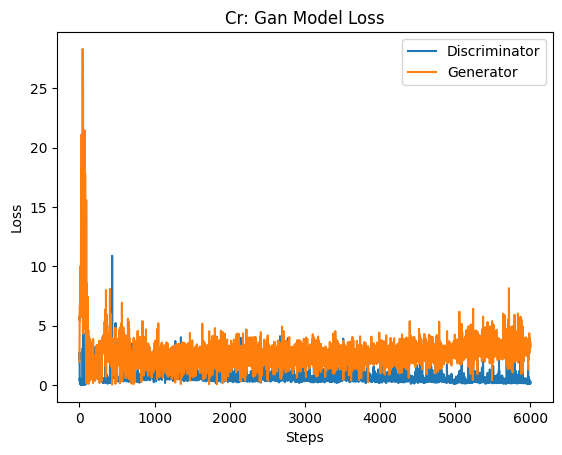

In [18]:
plt.plot(total_d_loss)
plt.plot(total_g_loss)
plt.legend(['Discriminator', 'Generator'])
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Cr: Gan Model Loss')